In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, cohen_kappa_score

In [2]:
ratio=[0.5,0.25,0.25] # expert&annot1&annot2
# neutral->[thres,+thres]
thres_annot = 0.25 # for annotation labels
thres = 0.05 # for model 

## read_exel

In [25]:
import openpyxl
xlsx = pd.read_excel(r'C:\Users\86180\Desktop\IC-DS\GROUP PROJECT\annotation.xlsx',header = None)
#df= pd.DataFrame(xlsx)
xlsx.head()


,0,1,2,3,4,5
0,0,0,0,0,0,0
1,1,-1,-1,-1,-1,-1
2,2,-1,-1,-1,-1,-1
3,3,-1,-1,-1,-1,-1
4,4,-1,-1,0,-1,-1


In [26]:
xlsx.columns = ['index','expert','annot1','annot2','textblob','vader']

## setting the labels

In [5]:
all_labels = [-1,0,1]
def compute_vote_agreement(row): 
    result = 0
    score = row[1]*ratio[0]+row[2]*ratio[1]+row[3]*ratio[2]
    if(score<-thres_annot):
        result = -1
    elif(score>thres_annot):  
        result = 1
    else:
        result = 0
    return result
 
# compute the agreed label via average score
xlsx["label"] = xlsx.apply(compute_vote_agreement, axis=1)

In [6]:
xlsx.head()

,index,expert,annot1,annot2,textblob,vader,label
0,0,0,0,0,0,0,0
1,1,-1,-1,-1,-1,-1,-1
2,2,-1,-1,-1,-1,-1,-1
3,3,-1,-1,-1,-1,-1,-1
4,4,-1,-1,0,-1,-1,-1


## Inter-Annotator Agreement metrics

In [7]:
import numpy as np
import pandas as pd
N = 300
# write an computation yourself without using the packages and function sklearn provide
def compute_confusion_matrix(y, yp):
    global all_labels
    result = np.zeros((len(all_labels),len(all_labels)))
    for i in range(N):
        result[all_labels.index(y[i])][all_labels.index(yp[i])]+=1
        #result[all_labels.index(y[i])][all_labels.index(yp[i])]+1 
    return result


def display_confusion_matrix(m):
    print(m)
    pass


### y is the ground truth labels, yp are the ones we compare with
### 以-1为正类

In [8]:
def compute_recall_score(y, yp):
    m = compute_confusion_matrix(y,yp)
    sum_=np.sum(m,axis=1) # 按行求和
   
    return m[0][0]/sum_[0]


def compute_precision_score(y, yp):
    m = compute_confusion_matrix(y,yp)
    sum_=np.sum(m,axis=0) # 按列求和
   
    return m[0][0]/sum_[0]


def compute_f1_score(y, yp):
    precision = compute_precision_score(y,yp)
    recall = compute_recall_score(y,yp)
    
    return 2*precision*recall/(precision+recall)


def compute_accuracy_score(y, yp):
    global N
    m = compute_confusion_matrix(y,yp)
    sum_1=0
    sum_2= N 
    for i in range(m.shape[0]):
        sum_1=sum_1+m[i][i]
        
    return sum_1/sum_2
 
def compute_cohen_kappa_score(y, yp):
    m = compute_confusion_matrix(y,yp)
    p0=0
    pe=0
    sum_1=np.sum(m,axis=1) # 按行求和
    sum_2=np.sum(m,axis=0) # 按列求和
    for i in range(len(all_labels)):
        p0+=m[i][i]
        pe+=sum_1[i]*sum_2[i]
    pe/=N
    return (p0-pe)/(N-pe)  # 分子分母同乘N

       
def compute_metrics(y, yp):
    m = compute_confusion_matrix(y, yp)
    display_confusion_matrix(m)

    print(f"   Recall: {compute_recall_score(y, yp):.4}")
    print(f"Precision: {compute_precision_score(y, yp):.4}")
    print(f"       F1: {compute_f1_score(y, yp):.4}")
    print(f" Accuracy: {compute_accuracy_score(y, yp):.4}")
    print(f"        K: {compute_cohen_kappa_score(y, yp):.4}")


In [9]:
def get_agreement_matrix(y_list):
    m=np.zeros((N,len(all_labels)))
    for i in range(len(y_list)):
        for j in range(N):
            m[j][all_labels.index(y_list[i][j])]+=1
    return m



def fleiss_kappa(testData, N, k, n): #testData表示要计算的数据，（N,k）表示矩阵的形状，说明数据是N行j列的，一共有n个标注人员
    dataMat = np.mat(testData, float)
    oneMat = np.ones((k, 1))
    sum = 0.0
    P0 = 0.0
    for i in range(N):
        temp = 0.0
        for j in range(k):
            sum += dataMat[i, j]
            temp += 1.0*dataMat[i, j]**2
        temp -= n
        temp /= (n-1)*n
        P0 += temp
    P0 = 1.0*P0/N
    ysum = np.sum(dataMat, axis=0)
    for i in range(k):
        ysum[0, i] = (ysum[0, i]/sum)**2
    Pe = ysum*oneMat*1.0
    ans = (P0-Pe)/(1-Pe)
    return ans[0, 0]

def compute_fleiss_kappa_score(y_list):
    # groundtruth_index denote the index of groundtruth value in y_list
    # Fleiss' Kappa score is an extension of Cohen's Kappa for more than 2 annotators
    matrix = get_agreement_matrix(y_list)
    return fleiss_kappa(matrix, N, len(all_labels), len(y_list))
    


## inner annotater agreement metrix 

In [10]:
# 3 annotators
print(f" Fleiss Kappa: {compute_fleiss_kappa_score([xlsx.expert.values,xlsx.annot1.values, xlsx.annot2.values]):.4}")

 Fleiss Kappa: 0.9343


In [11]:
# label & 3 annotators
print(f" Fleiss Kappa: {compute_fleiss_kappa_score([xlsx.label.values,xlsx.expert.values,xlsx.annot1.values, xlsx.annot2.values]):.4}")

 Fleiss Kappa: 0.9407


## calculate the two model:

In [12]:
print("--- Comparing vader vs groundtruth")
compute_metrics(xlsx.label.values, xlsx.vader.values)

--- Comparing vader vs groundtruth
[[ 94.   7.   1.]
 [  3. 185.   0.]
 [  0.   2.   8.]]
   Recall: 0.9216
Precision: 0.9691
       F1: 0.9447
 Accuracy: 0.9567
        K: 0.9104


In [13]:
print("--- Comparing textblob vs groundtruth")
compute_metrics(xlsx.label.values, xlsx.textblob.values)

--- Comparing textblob vs groundtruth
[[ 94.   8.   0.]
 [  0. 188.   0.]
 [  0.   2.   8.]]
   Recall: 0.9216
Precision: 1.0
       F1: 0.9592
 Accuracy: 0.9667
        K: 0.9304


## determin the best model by weighted average method

In [22]:

def weight_average(row,weight):
    global ratio
    global thres
    score = row[4]*weight+row[5]*(1-weight)
    result = 0
    if(score<-thres):
        result = -1
    elif(score>thres):  
        result = 1
    else:
        result = 0
    return result


In [23]:
xlsx["w_a"] = xlsx.apply(lambda row: weight_average(row,weight=0.1), axis=1)
xlsx["w_a"]

0      0
1     -1
2     -1
3     -1
4     -1
      ..
295    0
296   -1
297   -1
298    0
299    0
Name: w_a, Length: 300, dtype: int64

acc_max
1.0 0.75
prec_max
1.0 0.63


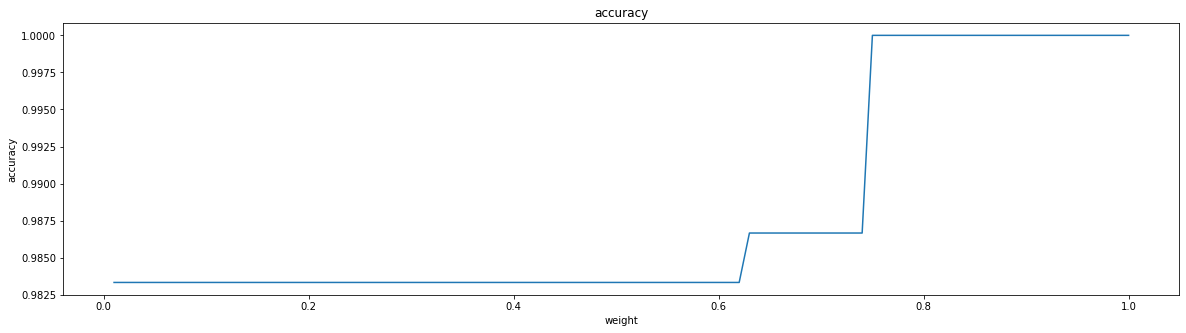

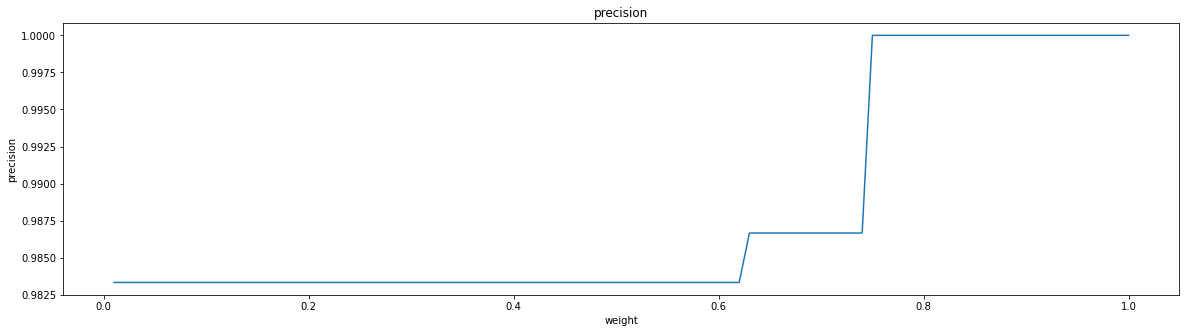

In [28]:
import matplotlib.pyplot as plt
weights = np.arange(0.01,1.01,0.01) # weight for textblob
acc_list = []
prec_list =[] 
for weight in weights:
    xlsx["w_a"] = xlsx.apply(lambda row: weight_average(row,weight), axis=1)
    acc = compute_accuracy_score(xlsx.w_a.values, xlsx.textblob.values)
    prec = compute_precision_score(xlsx.w_a.values, xlsx.textblob.values)
    acc_list.append(acc)
    prec_list.append(prec)
print('acc_max')   
print(max(acc_list),(acc_list.index(max(acc_list))+1)/100)  
print('prec_max')   
print(max(prec_list),(prec_list.index(max(prec_list))+1)/100)  

plt.figure(figsize=[20,5])
plt.title('accuracy')
plt.xlabel('weight')
plt.ylabel('accuracy')
plt.plot(weights,acc_list)
plt.show()

plt.figure(figsize=[20,5])
plt.title('precision')
plt.xlabel('weight')
plt.ylabel('precision')
plt.plot(weights,acc_list)
plt.show()

## get the score of vader and textblob

In [13]:
df=pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/text_cleaned_to_lable.csv')
df.columns = ['index','text']
df.head()

,index,text
0,25443,finds monkey pox hilarious!
1,35595,That monkey pox shit is nasty
2,139333,HEY You liberals want a zillion immigrants i...
3,51580,Too late and too little. It is the fault of ...
4,140788,"Admittedly, the combination of monkey pox be..."


## vader

In [17]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment(df):
    sid_obj = SentimentIntensityAnalyzer()
    vader =[]
    for col in df['text']:
        sentiment_dict = sid_obj.polarity_scores(col)
        compound = sentiment_dict['compound']
        vader.append(compound)
    df.insert(df.shape[1], 'sentiment', vader)
    return df

df = sentiment(df)
df['vader'] = df['sentiment'].apply(lambda x: -1 if x<-thres else( 0 if x<thres else 1 ))
df.head()

,index,text,sentiment,vader
0,25443,finds monkey pox hilarious!,0.4574,1
1,35595,That monkey pox shit is nasty,-0.8020,-1
2,139333,HEY You liberals want a zillion immigrants i...,0.9130,1
3,51580,Too late and too little. It is the fault of ...,-0.4019,-1
4,140788,"Admittedly, the combination of monkey pox be...",-0.3612,-1


## textblob

In [18]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emoji

In [19]:
df['text_deal_emoji'] = df['text'].astype(str).apply(lambda x: emoji.demojize(x))

In [20]:
pd.options.mode.chained_assignment = None

df['sentiment'] = df['text'].apply(lambda review: TextBlob(review).sentiment) 
df['Polarity'] = df['sentiment'].apply(lambda x: round(x[0],2)) 
df['Subjectivity'] = df['sentiment'].apply(lambda x: round(x[1],2)) 
df.head()

,index,text,sentiment,vader,text_deal_emoji,Polarity,Subjectivity
0,25443,finds monkey pox hilarious!,"(0.2875, 0.5)",1,finds monkey pox hilarious!,0.29,0.50
1,35595,That monkey pox shit is nasty,"(-0.4166666666666667, 0.6)",-1,That monkey pox shit is nasty,-0.42,0.60
2,139333,HEY You liberals want a zillion immigrants i...,"(0.27499999999999997, 0.35)",1,HEY You liberals want a zillion immigrants i...,0.27,0.35
3,51580,Too late and too little. It is the fault of ...,"(-0.17916666666666667, 0.3666666666666667)",-1,Too late and too little. It is the fault of ...,-0.18,0.37
4,140788,"Admittedly, the combination of monkey pox be...","(0.05000000000000001, 0.4666666666666666)",-1,"Admittedly, the combination of monkey pox be...",0.05,0.47


In [21]:
df.drop(columns=['sentiment'],inplace =True)

In [22]:
df['textblob'] = df['Polarity'].apply(lambda x: -1 if x<-thres else( 0 if x<thres else 1 ))

In [23]:
df.head()

,index,text,vader,text_deal_emoji,Polarity,Subjectivity,textblob
0,25443,finds monkey pox hilarious!,1,finds monkey pox hilarious!,0.29,0.50,1
1,35595,That monkey pox shit is nasty,-1,That monkey pox shit is nasty,-0.42,0.60,-1
2,139333,HEY You liberals want a zillion immigrants i...,1,HEY You liberals want a zillion immigrants i...,0.27,0.35,1
3,51580,Too late and too little. It is the fault of ...,-1,Too late and too little. It is the fault of ...,-0.18,0.37,-1
4,140788,"Admittedly, the combination of monkey pox be...",-1,"Admittedly, the combination of monkey pox be...",0.05,0.47,1


In [28]:
xlsx['vader'] = df['vader']
xlsx['textblob'] = df['textblob']
xlsx['index'] = df['index']

In [32]:
xlsx.to_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/annotation.csv')
df.to_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/300.csv')

In [31]:
xlsx.head()

,index,expert,annot1,annot2,textblob,vader
0,25443,0,0,0,1,1
1,35595,-1,-1,-1,-1,-1
2,139333,-1,-1,-1,1,1
3,51580,-1,-1,-1,-1,-1
4,140788,-1,-1,0,1,-1
